# Training Demo Enformer Celltyping

This workbook steps through training Enformer Celltyping using the small subset of data available in the repo.

## Step 1 Create Enformer Celltyping model 

Enformer Celltyping fine-tunes using the enformer model which is available from tensorflow hub and needs to be downloaded (if you ran `python bin/download_Enformer_Celltyping_dependencies.py` from the README it will have been downloaded already). The enformer weights are lifted and added to a recreated enformer model with the final layers after the attention layers removed to make the model more suitable for fine-tuning, removing its task-specific layers but keeping it's DNA-interaciton information.

Let's initiate Enformer Celltyping. Training Enformer Celltyping was done in two steps:

1. Pretrain a split model
Since the enformer model is being used to embed the DNA information in Enformer Celltyping, the weights for the DNA information are already sensibly initiated. To avoid the DNA information dominating the final predictions in Enformer Celltyping (and the model just ignoring the chromatin accessibility information), we first trained Enformer Celltyping with a split architecture as some 'warm-up' steps. For a given genomic position, the model predicts the (1) average signal at this position and the (2) quantile distribution of the signal for the 104 trianing cell types from the DNA information and the (3) delta i.e. difference between the average signal and the cell type-specific signal for the cell type of interest from the chromatin accessibility information. We show how this two-stage training approach improves performance in our manuscript.

This warm-up stage is run for 1,000 steps where each step contains the full batch size of 128 positions. 

Here, for the demo, we will just train for 20 steps on a small dataset but note this will affect overall performance.


In [1]:
#create Enformer Celltyping - for training
from EnformerCelltyping.enf_celltyping import Enformer_Celltyping
from EnformerCelltyping.utils import pearsonR
import tensorflow as tf

assays = ['h3k27ac', 'h3k4me1', 'h3k4me3', 'h3k9me3', 'h3k27me3', 'h3k36me3']
learning_rate = 0.0002

#Using all the model default parameters for the architecture
#Set use_prebuilt_model to False since we want to train 
#Enformer Celltyping from scratch
model = Enformer_Celltyping(assays=assays,
                            use_prebuilt_model=False,
                            model_arch = 'split') #model_arch = split creates the architecture for the pre-training
#compile the model, the model is separated into 3 channels: 
# 1. DNA channel which predicts an average histone mark score across
#    all trainig cell types
# 2. The DNA channel is also used to predict average quantile distribution
#    histone mark score across all trainig cell types. We show that adding 
#    this output improved overall performance in our manuscript.
# 3. Chromatin accessibility channel which predicts the delta between
#    the average histone mark value for that region and the cell type-
#    specific one.
# Thus there are 3 loss functions
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
          loss={'avg':tf.keras.losses.poisson,
                'delta':tf.keras.losses.mean_squared_error,
                'quant':tf.keras.losses.categorical_crossentropy,#since a distribution (actually 6 dists)
                },
          metrics=['mse',pearsonR])

#Let's view the model
model.summary()

2023-09-08 09:58:48.073014: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-09-08 09:58:50.899761: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-09-08 09:58:50.946427: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-08 09:58:50.946447: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (workstation-neurogenomics): /proc/driver/nvidia/version does not exist
2023-09-08 09:58:50.946953: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler 

Model: "EnfCelltyping"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dnaInput (InputLayer)           [(None, 896, 1536)]  0                                            
__________________________________________________________________________________________________
dense1_quant (Dense)            (None, 896, 1536)    2360832     dnaInput[0][0]                   
__________________________________________________________________________________________________
ChromAccessLclInput (InputLayer [(None, 1562)]       0                                            
__________________________________________________________________________________________________
dropout1_quant (Dropout)        (None, 896, 1536)    0           dense1_quant[0][0]               
______________________________________________________________________________________

This model does not include the layers of enformer since the DNA for the demo regions
has already been passed through the pre-trained enformer model. Since the layers are frozen 
these weights will not update so we can save on compute time and RAM by pre-running it. If
you want to build a version of Enformer Celltyping with the enformer layers run:

```
from EnformerCelltyping.constants import DATA_PATH
from EnformerCelltyping.enf_celltyping import Enformer_Celltyping

assays = ['h3k27ac', 'h3k4me1', 'h3k4me3', 'h3k9me3', 'h3k27me3', 'h3k36me3']

#Enformer Celltyping from scratch
#Include enformer layers
model = Enformer_Celltyping(assays=assays,
                            use_prebuilt_model=False,
                            model_arch = 'split',
                            enf_path = str(DATA_PATH / "enformer_model"))
```

## Step 2 Get data loader

We have include pre-computed training data with 5 cell types from EpiMap at two 
locations each in chromosome 10. We will train on these using a tensorflow data
loader.

If you want more information on the creation of this data, see [full_training_recreation.ipynb](https://github.com/neurogenomics/EnformerCelltyping/blob/master/full_training_recreation.ipynb)

In [2]:
#Now let's get the data ready
from EnformerCelltyping.constants import DATA_PATH
import glob

#get links to precomputed, demo training data
#5 cell types from EpiMap at two locations each in chromosome 10
train_data = glob.glob(str(DATA_PATH/'demo/*[0-9].npz'))

In [3]:
#Now use the provided custom data loader on this data
from EnformerCelltyping.utils import PreSavedDataGen

train_dataloader = PreSavedDataGen(files=train_data,
                                   batch_size=2,
                                   combn_y = False)#since this is the pre-training stage we want 3 output channels

In [4]:
#test ouput
one_samp = next(iter(train_dataloader))
#shape of X inputs
print("X input to model shape")
print({key: dat.shape for key, dat in one_samp[0].items()})
#shape of Y inputs
print("Y output from model shape")
print({key: dat.shape for key, dat in one_samp[1].items()})
#You can see the three output channels for the split pre-training

X input to model shape
{'dna': TensorShape([2, 896, 1536]), 'chrom_access_lcl': TensorShape([2, 1562]), 'chrom_access_gbl': TensorShape([2, 14592])}
Y output from model shape
{'avg': TensorShape([2, 896, 6]), 'delta': TensorShape([2, 896, 6]), 'quant': TensorShape([2, 896, 6, 10])}


## Step 3 Train Enformer Celltyping

Now we have our data loader and model ready we can start the pretraining.

In [5]:
n_steps = 20

import datetime
strt = datetime.datetime.now()

# Train the model
model.fit(
        train_dataloader,
        epochs=n_steps,
        verbose=2
    )


end = datetime.datetime.now()
print('Time taken: ',end-strt)

Epoch 1/20


2023-09-08 09:58:53.054379: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-09-08 09:58:53.054801: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1996250000 Hz


1/1 - 7s - loss: 3.4526 - avg_loss: 0.8944 - delta_loss: 0.1434 - quant_loss: 2.4149 - avg_mse: 0.2708 - avg_pearsonR: -3.8901e-02 - delta_mse: 0.1434 - delta_pearsonR: -5.2481e-04 - quant_mse: 0.0376 - quant_pearsonR: -7.1578e-03
Epoch 2/20
1/1 - 4s - loss: 3.1921 - avg_loss: 0.8686 - delta_loss: 0.2172 - quant_loss: 2.1064 - avg_mse: 0.2414 - avg_pearsonR: 0.2703 - delta_mse: 0.2172 - delta_pearsonR: -6.5134e-03 - quant_mse: 0.0294 - quant_pearsonR: 0.0242
Epoch 3/20
1/1 - 4s - loss: 2.9514 - avg_loss: 0.8759 - delta_loss: 0.1801 - quant_loss: 1.8954 - avg_mse: 0.1359 - avg_pearsonR: 0.5722 - delta_mse: 0.1801 - delta_pearsonR: 0.1083 - quant_mse: 0.0226 - quant_pearsonR: 0.0242
Epoch 4/20
1/1 - 4s - loss: 2.7749 - avg_loss: 0.8628 - delta_loss: 0.1683 - quant_loss: 1.7438 - avg_mse: 0.1160 - avg_pearsonR: 0.7106 - delta_mse: 0.1683 - delta_pearsonR: 0.0752 - quant_mse: 0.0200 - quant_pearsonR: -4.8860e-02
Epoch 5/20
1/1 - 4s - loss: 2.6265 - avg_loss: 0.8304 - delta_loss: 0.2012 - q

Now we have sensibly initiated the weights for both the DNA and chromatin accessibility streams, we can combine them to give a cell type-specific prediciton as an output.

First let's save these weights to load with the combined architecture:

In [6]:
#just use project directory for now, will delete it after
from EnformerCelltyping.constants import PROJECT_PATH
model.save_weights(PROJECT_PATH / 'test_split_weights.h5')

Now we can more on to stage 2 of trianing

2. Train a combined model
Now we have sensibly initiated the weights for both the DNA and chromatin accessibility streams, we can combine them to give a cell type-specific prediciton as an output. For the manuscript, we trained the model for 4 full epochs (6940 steps of 128 batch size - 888,320 positions) stopping when it started to overfit, taking 1.5 days on a 80GB RAM GPU.

Here we will just train for 20 steps on the same , small sample data.

First, let's create Enformer CElltypign with the combined architecture

In [7]:
model = Enformer_Celltyping(use_prebuilt_model=True,
                            #path to stage 1 (split) training weights
                            enf_celltyping_pth = str(PROJECT_PATH / 'test_split_weights.h5')
                           )

learning_rate = 0.0005 #higher learning rate than pretraining
#compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.poisson,
              metrics=['mse',pearsonR])
#Let's view the model
model.summary() #note more trainable parameters

Model: "EnformerCelltyping"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dnaInput (InputLayer)           [(None, 896, 1536)]  0                                            
__________________________________________________________________________________________________
dense1_quant (Dense)            (None, 896, 1536)    2360832     dnaInput[0][0]                   
__________________________________________________________________________________________________
ChromAccessLclInput (InputLayer [(None, 1562)]       0                                            
__________________________________________________________________________________________________
dense1_dna (Dense)              (None, 896, 1536)    2360832     dnaInput[0][0]                   
_________________________________________________________________________________

Like with pretraining, this model does not include the layers of enformer since the DNA for the demo regions has already been passed through the pre-trained enformer model. Since the layers are frozen these weights will not update so we can save on compute time and RAM by pre-running it. If you want to build a version of Enformer Celltyping with the enformer layers run:

```
from EnformerCelltyping.constants import DATA_PATH
from EnformerCelltyping.enf_celltyping import Enformer_Celltyping

assays = ['h3k27ac', 'h3k4me1', 'h3k4me3', 'h3k9me3', 'h3k27me3', 'h3k36me3']

#Enformer Celltyping from scratch
#Include enformer layers
model = Enformer_Celltyping(assays=assays,
                            use_prebuilt_model=True,
                            enf_celltyping_pth = str(PROJECT_PATH / 'test_split_weights.h5'),
                            enf_path = str(DATA_PATH / "enformer_model"))
```

Next, we need to update our dataloader to give the cell type-specific outputs not separate channels:

In [8]:
#Now use the provided custom data loader on this data
from EnformerCelltyping.utils import PreSavedDataGen

train_dataloader = PreSavedDataGen(files=train_data,
                                   batch_size=1)

In [12]:
#test ouput
one_samp = next(iter(train_dataloader))
#shape of X inputs
print("X input to model shape")
print({key: dat.shape for key, dat in one_samp[0].items()})
#shape of Y inputs
print("Y output from model shape")
print({'y': one_samp[1].shape})
#You can see there is just one output now for y - the cell type-specific signal

X input to model shape
{'dna': TensorShape([1, 896, 1536]), 'chrom_access_lcl': TensorShape([1, 1562]), 'chrom_access_gbl': TensorShape([1, 14592])}
Y output from model shape
{'y': TensorShape([1, 896, 6])}




Now let's train Enformer Celltyping

In [13]:
n_steps = 20

import datetime
strt = datetime.datetime.now()

# Train the model
model.fit(
        train_dataloader,
        epochs=n_steps,
        verbose=2
    )


end = datetime.datetime.now()
print('Time taken: ',end-strt)

Epoch 1/20
1/1 - 9s - loss: 0.8667 - mse: 0.2238 - pearsonR: -5.1377e-03
Epoch 2/20
1/1 - 5s - loss: 0.8830 - mse: 0.4591 - pearsonR: 0.0376
Epoch 3/20
1/1 - 5s - loss: 0.7279 - mse: 0.0683 - pearsonR: 0.8450
Epoch 4/20
1/1 - 5s - loss: 0.8512 - mse: 0.4223 - pearsonR: 0.0269
Epoch 5/20
1/1 - 5s - loss: 0.8179 - mse: 0.2546 - pearsonR: 0.0680
Epoch 6/20
1/1 - 5s - loss: 0.7064 - mse: 0.2834 - pearsonR: 0.8185
Epoch 7/20
1/1 - 5s - loss: 0.6195 - mse: 0.0646 - pearsonR: 0.9235
Epoch 8/20
1/1 - 5s - loss: 0.7700 - mse: 0.1369 - pearsonR: 0.0014
Epoch 9/20
1/1 - 5s - loss: 0.6713 - mse: 0.1871 - pearsonR: 0.8188
Epoch 10/20
1/1 - 5s - loss: 0.8592 - mse: 0.3274 - pearsonR: 0.0751
Epoch 11/20
1/1 - 5s - loss: 0.7585 - mse: 0.1538 - pearsonR: 0.8483
Epoch 12/20
1/1 - 5s - loss: 0.7601 - mse: 0.1991 - pearsonR: 0.7637
Epoch 13/20
1/1 - 5s - loss: 1.0428 - mse: 0.4666 - pearsonR: 0.0634
Epoch 14/20
1/1 - 5s - loss: 0.9290 - mse: 0.2159 - pearsonR: 0.0326
Epoch 15/20
1/1 - 5s - loss: 0.8364 - 

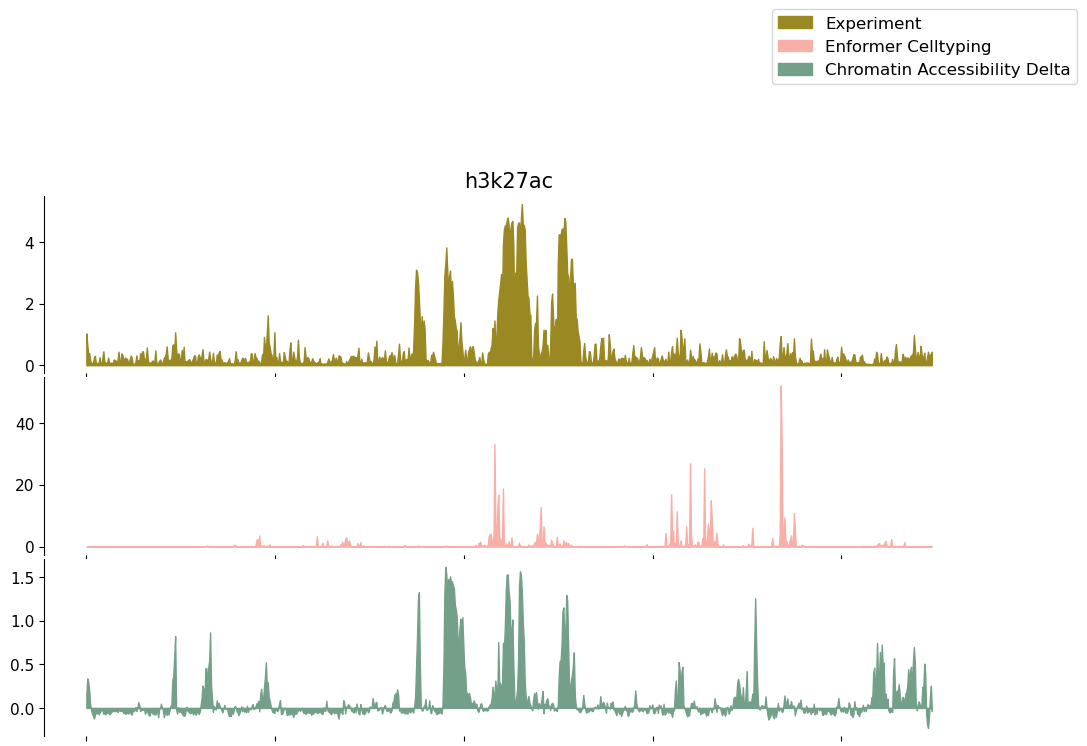

In [15]:
#Now let's predict one of the regions
#function to plot multiple tracks with the mdoel prediction, the actual and the local chrom access

#actual signal
signal = one_samp[1].numpy()

#We can get the local chromatin accessibility data from X
#This is the change in chromatin acessibility between the
#cell type of interest and the avg from trainig cell types.
chrom_access_lcl = one_samp[0]['chrom_access_lcl'].numpy()
#chrom access local is wider than output window so need to cut it
buff = (chrom_access_lcl.shape[1] - signal.shape[1])//2
chrom_access_lcl = chrom_access_lcl[:,buff:chrom_access_lcl.shape[1]-buff]
#now just repeat track for each plot and swap axis
import numpy as np
chrom_access_lcl = np.tile(chrom_access_lcl,[6,1]).swapaxes(0, 1)


model_pred = model.predict(one_samp[0])

from EnformerCelltyping.utils import plot_tracks
#just plot h3k27ac
plot_tracks(signal[0,:,0:1],model_pred[0,:,0:1],chrom_access_lcl[:,0:1],
            labels=['h3k27ac'],
            same_y=False,
            nme_p1='Experiment',nme_p2='Enformer Celltyping',
            nme_p3='Chromatin Accessibility Delta',
            pal =["#9A8822","#F8AFA8","#74A089"],
            figsize=(12., 6.))

Note that performance here is very poor so we need to train longer, on more data and avoid overfitting! But I hope this explains the training process